In [2]:
import tensorflow as tf
import dask.dataframe as dd
from waymo_open_dataset import v2
import glob
import matplotlib.pyplot as plt
from waymo_open_dataset.utils.range_image_utils import build_camera_depth_image
from waymo_open_dataset.v2.perception.utils import lidar_utils

In [48]:
search_path = '/home/meowater/Documents/ssd_drive/training/lidar/'
file_list = glob.glob(search_path + '*.parquet')


798


In [4]:
dataset_dir = '/home/meowater/Documents/ssd_drive/training/'

def read(tag: str, context_name) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/*{context_name}.parquet')
  return dd.read_parquet(paths)

In [5]:
def get_extrinsic(calibration):
  """Projects from vehicle coordinate system to image with global shutter.

  Arguments:
    calibration: Camera calibration details (including intrinsics/extrinsics).
  Returns:
    Array of shape [N, 3], with the latter dimension composed of (u, v, ok).
  """

  # Populate camera image metadata. Velocity and latency stats are filled with
  # zeroes.
  extrinsic = tf.reshape(
      tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
      [1, 4, 4])

  # Perform projection and return projected image coordinates (u, v, ok).
  return extrinsic

In [49]:
# Lazily read DataFrames for all components.
# context_name = '15832924468527961_1564_160_1584_160'
context_name = '3270384983482134275_3220_000_3240_000'
# context_name = '2598465433001774398_740_670_760_670'
# context_name = '15832924468527961_1564_160_1584_160'
# context_name = '5083516879091912247_3600_000_3620_000'
cam_img_df = read('camera_image', context_name)
lidar_df = read('lidar', context_name)

lidar_calib_df = read('lidar_calibration', context_name)
camera_calib_df = read('camera_calibration', context_name)
vehicle_pose_df = read('vehicle_pose', context_name)
projections_df = read('lidar_camera_projection', context_name)

print(len(cam_img_df))
print(len(lidar_df))
print(len(lidar_calib_df))
print(len(camera_calib_df))
print(len(projections_df))

990
990
5
5
990


In [35]:
_, r_cam = next(iter(cam_img_df.iterrows()))
curr_image = v2.CameraImageComponent.from_dict(r_cam)

_, r_lidar = next(iter(lidar_df.iterrows()))
lidar = v2.LiDARComponent.from_dict(r_lidar)

_, r_project = next(iter(projections_df.iterrows()))
projections = v2.LiDARCameraProjectionComponent.from_dict(r_project)

_, r_cam_config = next(iter(camera_calib_df.iterrows()))
cam_config = v2.CameraCalibrationComponent.from_dict(r_cam_config)

_, r_lidar_config = next(iter(lidar_calib_df.iterrows()))
lidar_config = v2.LiDARCalibrationComponent.from_dict(r_lidar_config)



In [36]:

lidar_coords = lidar_utils.convert_range_image_to_cartesian(lidar.range_image_return1, lidar_config)
lidar_coords = tf.expand_dims(lidar_coords, axis=0)
camera_extrinsic = get_extrinsic(cam_config)

camera_image_size = [cam_config.height, cam_config.width]
test2 = projections.range_image_return1.tensor
test2 = tf.expand_dims(test2, axis=0)

test = build_camera_depth_image(lidar_coords, camera_extrinsic,
                                camera_projection=test2,
                                camera_image_size=camera_image_size,
                                camera_name=1)

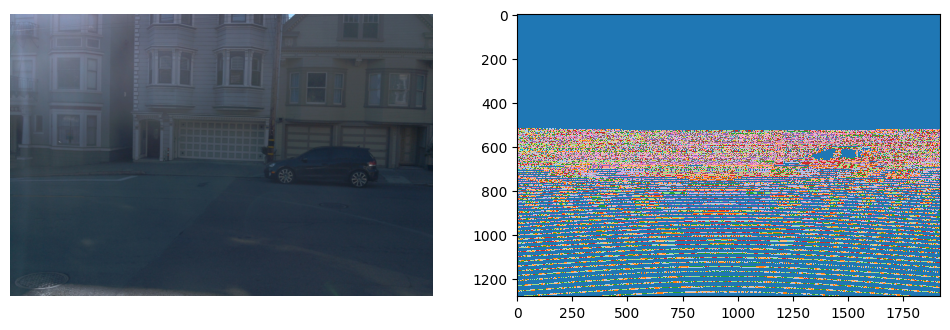

In [47]:
# Ensure the pixel values are in the valid range [0, 1]


test_img = tf.squeeze(test, axis=0)
img_array = test_img.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(tf.image.decode_jpeg(curr_image.image, ))
# ax1.grid(False)
ax1.axis('off')

ax2.imshow(img_array, cmap='tab20', vmin=0, vmax=1.5)
# ax2.grid(False)
# ax2.axis('off')
plt.show()